In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns

import cartopy.crs as ccrs

import statsmodels

import os
from tqdm import tqdm, trange

from convertbng.util import convert_bng, convert_lonlat
import utm

In [9]:
# code and species dictionary

code_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Alberta/To_look_at/Banff_NP_Freshwater_Lake_Fish_Index_2017_data_dictionary.csv')
# code_df = code_df.iloc[:-6]
code_df.rename(columns={'Data_Value_Valeur_de_la_donnée': 'code_name', 
                        'Value_Description_EN_Description_de_la_valeur': 'common_name'}, inplace=True)
code_df = code_df[['code_name', 'common_name']]
code_df['common_name'] = code_df['common_name'].str.lower().str.replace(' ', '_')
display(code_df.sample(5))

dict_code_name = code_df.set_index('code_name').to_dict()['common_name']

,code_name,common_name
8,LNSC,longnose_sucker
15,SCUL,sculpin_spp
39,NRDC,northern_redbelly_dace
24,BURB,burbot
10,MATR,marstoni_trout


In [10]:
new_codes = {'LNDC': 'longnose_dace', 'BNTR': 'brown_trout', 'RNTR1': 'rainbow_trout', 'CTTR1': 'cutthroat_trout', 
             'WHSC': 'white_sucker', 'BLTRCTTR(N&I)': 'bull_trout_x_cutthroat_trout', 'CTTR(hybrids)': 'cutthroat_trout', 
             'CTTRhybrids': 'cutthroat_trout', 'SUCK': 'white_sucker'}

dict_code_name.update(new_codes)

In [18]:
# Species dictionay

species_name_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/species_name_dictionary.csv')

dict_species_name = species_name_df.set_index('common_name').to_dict()['scientific_name']

In [12]:
species_name_df = pd.DataFrame.from_dict({'common_name': list(dict_species_name.keys()), 
                                        'scientific_name' : list(dict_species_name.values())})
# species_name_df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/species_name_dictionary.csv', index=False)

In [13]:
# Quebec map: http://www.environnement.gouv.qc.ca/eau/guide/localisation.asp#onglets

# Fish consumption 

In [14]:
# df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Gen Fish Quebec Fish Consumption Data - Sheet1.csv')
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Quebec/quebec_fish_consumption_oct_07_2020.csv')

df['Latitude'] = df['Latitude'].str.replace(',', '.').astype(float)
df['Longitude'] = df['Longitude'].str.replace(',', '.').astype(float)
df.rename(columns={"Plan d'eau": 'water_body', 'Bassin Primaire': 'primary_bassin', 
                   'Bassin secondaire': 'secondary_bassin'}, inplace=True)
display(df.tail())

# df.to_csv('/mnt/c/Users/imrit/Desktop/Gen_fish_Sharma/Quebec/quebec_fish_consumption_oct_07_2020.csv', index=False)

,water_body,primary_bassin,secondary_bassin,Latitude,Longitude,Site,Species_1,Species_2,Species_3,Species_4,...,Species_6,Species_7,Species_8,Species_9,Species_10,Species_11,Species_12,Species_13,Species_14,Species_15
1261,"Jeannine, Lac","Saguenay, Rivière","Iroquois, Rivière aux",48.399110,-72.502142,NaN,Omble de fontaine,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1262,"Loutre, Lac à la","Saguenay, Rivière","Iroquois, Rivière aux",48.407286,-72.444312,NaN,Omble de fontaine,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1263,"Rond, Lac","Saguenay, Rivière","Ouiatchouan, Rivière",48.374990,-72.329779,NaN,Omble de fontaine,Touladi,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1264,"Carpe, Lac à la","Saguenay, Rivière","Métabetchouane, Rivière",48.218289,-71.861658,NaN,Omble de fontaine,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1265,"Vert, Lac","Saguenay, Rivière","Belle Rivière, La",48.364633,-71.642305,NaN,Éperlan arc-en-ciel,Meunier noir,Omble de fontaine,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Convert species name to common english names

In [15]:
species_df = df[[col for col in df.columns if 'Species' in col]]
# display(species_df.head())

species_list = []
for col in species_df.columns:
    uniques = species_df[col].unique()
    species_list.append(uniques)

species_list = np.unique([species for sublist in species_list for species in sublist])
print(len(species_list))
print(species_list)
# np.unique(species_df.values)

# species_df = pd.DataFrame(species_list)
# species_df.rename(columns={0: 'French_name'}, inplace=True)
# species_df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/species_name.csv', index=False)

species_name_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/species_name.csv')
# display(species_name_df.head())

dict_species_name = pd.Series(species_name_df['English_name'].values, index=species_name_df['French_name']).to_dict()
dict_species_name

48
['Achigan' "Anguille d'Amérique" 'Barbotte Brune' 'Barbotte brune'
 'Barbue de rivière' 'Baret' 'Brochet maillé' 'Carpe allemande'
 'Chevalier blanc' 'Chevalier rouge' 'Cisco de lac' 'Crapet de roche'
 'Doré jaune' 'Doré noir' 'Esturgeon jaune' 'Esturgeon noir'
 'Flétan du Groenland' 'Grand Brochet' 'Grand brochet' 'Grand corégone'
 'Grand corégone ' 'Laquaiche' 'Lotte' 'Lotte ' 'Malachigan'
 'Marigane noire' 'Maskinongé' 'Meunier Noir' 'Meunier noir'
 'Meunier rouge' 'Morue de roche' 'Moxostome' 'Ménomini rond'
 'Omble chevalier' 'Omble de fontaine' 'Ouananiche' 'Ouitouche'
 'Perchaude' 'Poulamon atlantique' 'Saumon atlantique' 'Sébaste' 'Touladi'
 'Touladi ' 'Truite arc-en-ciel' 'Truite brune' 'Truite moulac' 'nan'
 'Éperlan arc-en-ciel']


{'Achigan': 'largemouth_bass',
 "Anguille d'Amérique": 'american_eel',
 'Barbotte Brune': 'brown_bullhead',
 'Barbotte brune': 'brown_bullhead',
 'Barbue de rivière': 'channel_catfish',
 'Baret': 'white_perch',
 'Brochet maillé': 'chain_pickerel',
 'Carpe allemande': 'common_carp',
 'Chevalier blanc': 'silver_redhorse',
 'Chevalier rouge': 'shorthead_redhorse',
 'Cisco de lac': 'cisco',
 'Crapet de roche': 'rock_bass',
 'Doré jaune': 'walleye',
 'Doré noir': 'sauger',
 'Esturgeon jaune': 'lake_sturgeon',
 'Esturgeon noir': 'gulf_sturgeon',
 'Flétan du Groenland': 'greenland_halibut',
 'Grand Brochet': 'northern_pike',
 'Grand brochet': 'northern_pike',
 'Grand corégone': 'lake_whitefish',
 'Grand corégone ': 'lake_whitefish',
 'Laquaiche': 'goldeneye',
 'Lotte': 'burbot',
 'Lotte ': 'burbot',
 'Malachigan': 'freshwater_drum',
 'Marigane noire': 'black_crappie',
 'Maskinongé': 'muskellunge',
 'Meunier Noir': 'white_sucker',
 'Meunier noir': 'white_sucker',
 'Meunier rouge': 'longnose_su

In [16]:
df.replace(dict_species_name, inplace=True)
display(df.head(10))

,water_body,primary_bassin,secondary_bassin,Latitude,Longitude,Site,Species_1,Species_2,Species_3,Species_4,...,Species_6,Species_7,Species_8,Species_9,Species_10,Species_11,Species_12,Species_13,Species_14,Species_15
0,"Saint-François, Lac","Saint-Laurent, Fleuve",NaN,45.095566,-74.434094,Île au Mouton,largemouth_bass,brown_bullhead,walleye,northern_pike,...,yellow_perch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Richelieu, Rivière","Richelieu, Rivière",NaN,45.029876,-73.332214,Noyan,largemouth_bass,brown_bullhead,white_perch,walleye,...,white_sucker,yellow_perch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Wallace, Lac","Connecticut, River",NaN,45.015270,-71.632880,NaN,largemouth_bass,brown_bullhead,chain_pickerel,white_sucker,...,brown_trout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Lippé, Lac","Saint-François, Rivière","Massawippi, Rivière",45.098055,-71.656944,NaN,rainbow_trout,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Lyster, Lac","Saint-François, Rivière","Massawippi, Rivière",45.029304,-71.907721,NaN,lake_trout,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Tomifobia, Rivière","Saint-François, Rivière","Massawippi, Rivière",45.024953,-72.044600,"Judd's Mills, 1,7 km du pont, amont",white_sucker,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"Tomifobia, Rivière","Saint-François, Rivière","Massawippi, Rivière",45.059551,-72.130455,Tomifobia,white_sucker,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"Memphrémagog, Lac","Saint-François, Rivière","Magog, Rivière",45.102655,-72.180408,Baie de Fitch,largemouth_bass,brown_bullhead,white_sucker,yellow_perch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"Memphrémagog, Lac","Saint-François, Rivière","Magog, Rivière",45.108686,-72.280537,Près du centre du lac,largemouth_bass,brown_bullhead,white_perch,chain_pickerel,...,northern_pike,white_sucker,atlantic_salmon,yellow_perch,lake_trout,brown_trout,NaN,NaN,NaN,NaN
9,"Lovering, Lac","Saint-François, Rivière","Magog, Rivière",45.179984,-72.158771,NaN,largemouth_bass,brown_bullhead,chain_pickerel,white_sucker,...,lake_trout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### get water body type

In [20]:
df['type_water_body'] = df['water_body'].str.split(',').str.get(1)
df['type_primary_bassin'] = df['primary_bassin'].str.split(',').str.get(1)
df['type_secondary_bassin'] = df['secondary_bassin'].str.split(',').str.get(1)
df.head()

,water_body,primary_bassin,secondary_bassin,latitude,longitude,site,largemouth_bass,american_eel,brown_bullhead,channel_catfish,...,lake_trout,rainbow_trout,brown_trout,splake,rainbow_smelt,lat_long,year,type_water_body,type_primary_bassin,type_secondary_bassin
0,"Saint-François, Lac","Saint-Laurent, Fleuve",NaN,45.095566,-74.434094,Île au Mouton,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,45.096_-74.434,2016,Lac,Fleuve,NaN
1,"Richelieu, Rivière","Richelieu, Rivière",NaN,45.029876,-73.332214,Noyan,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,45.03_-73.332,2016,Rivière,Rivière,NaN
2,"Wallace, Lac","Connecticut, River",NaN,45.015270,-71.632880,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,45.015_-71.633,2016,Lac,River,NaN
3,"Lippé, Lac","Saint-François, Rivière","Massawippi, Rivière",45.098055,-71.656944,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,45.098_-71.657,2016,Lac,Rivière,Rivière
4,"Lyster, Lac","Saint-François, Rivière","Massawippi, Rivière",45.029304,-71.907721,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,45.029_-71.908,2016,Lac,Rivière,Rivière


In [21]:
type_water_list = []
for col in ['type_water_body', 'type_primary_bassin', 'type_secondary_bassin']:
    uniques = df[col].unique()
    type_water_list.append(uniques)

type_water_list = np.unique([type_water for sublist in type_water_list for type_water in sublist])
# print(len(type_water_list))
# print(type_water_list)
# np.unique(species_df.values)

# water_df_names = pd.DataFrame(type_water_list)
# water_df_names.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/water_df_names.csv', index=False)

water_df_names= pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/water_df_names.csv')
display(water_df_names.head())

dict_water_type_name = pd.Series(water_df_names['english_name'].values, index=water_df_names['french_name']).to_dict()
# dict_water_type_name

,french_name,english_name
0,Baie du,bay
1,Bras,inlet
2,Bras du,inlet
3,Cours d'eau,watercourse
4,Crique,estuary


In [22]:
df.replace(dict_water_type_name, inplace=True)
display(df)

,water_body,primary_bassin,secondary_bassin,latitude,longitude,site,largemouth_bass,american_eel,brown_bullhead,channel_catfish,...,lake_trout,rainbow_trout,brown_trout,splake,rainbow_smelt,lat_long,year,type_water_body,type_primary_bassin,type_secondary_bassin
0,"Saint-François, Lac","Saint-Laurent, Fleuve",NaN,45.095566,-74.434094,Île au Mouton,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,45.096_-74.434,2016,lake,river,NaN
1,"Richelieu, Rivière","Richelieu, Rivière",NaN,45.029876,-73.332214,Noyan,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,45.03_-73.332,2016,river,river,NaN
2,"Wallace, Lac","Connecticut, River",NaN,45.015270,-71.632880,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,45.015_-71.633,2016,lake,river,NaN
3,"Lippé, Lac","Saint-François, Rivière","Massawippi, Rivière",45.098055,-71.656944,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,45.098_-71.657,2016,lake,river,river
4,"Lyster, Lac","Saint-François, Rivière","Massawippi, Rivière",45.029304,-71.907721,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,45.029_-71.908,2016,lake,river,river
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,"Jeannine, Lac","Saguenay, Rivière","Iroquois, Rivière aux",48.399110,-72.502142,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,48.399_-72.502,2016,lake,river,river
1262,"Loutre, Lac à la","Saguenay, Rivière","Iroquois, Rivière aux",48.407286,-72.444312,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,48.407_-72.444,2016,lake,river,river
1263,"Rond, Lac","Saguenay, Rivière","Ouiatchouan, Rivière",48.374990,-72.329779,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,48.375_-72.33,2016,lake,river,river
1264,"Carpe, Lac à la","Saguenay, Rivière","Métabetchouane, Rivière",48.218289,-71.861658,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,48.218_-71.862,2016,lake,river,river


### Make species columns

In [17]:
for col in species_name_df['English_name'].unique():
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
display(df.head())    

,water_body,primary_bassin,secondary_bassin,Latitude,Longitude,Site,Species_1,Species_2,Species_3,Species_4,...,atlantic_salmon,fallfish,yellow_perch,winter_cod,rose_fish,lake_trout,rainbow_trout,brown_trout,splake,rainbow_smelt
0,"Saint-François, Lac","Saint-Laurent, Fleuve",NaN,45.095566,-74.434094,Île au Mouton,largemouth_bass,brown_bullhead,walleye,northern_pike,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Richelieu, Rivière","Richelieu, Rivière",NaN,45.029876,-73.332214,Noyan,largemouth_bass,brown_bullhead,white_perch,walleye,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Wallace, Lac","Connecticut, River",NaN,45.015270,-71.632880,NaN,largemouth_bass,brown_bullhead,chain_pickerel,white_sucker,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,"Lippé, Lac","Saint-François, Rivière","Massawippi, Rivière",45.098055,-71.656944,NaN,rainbow_trout,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4,"Lyster, Lac","Saint-François, Rivière","Massawippi, Rivière",45.029304,-71.907721,NaN,lake_trout,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [23]:
df.drop(columns=[col for col in df.columns if 'Species_' in col], inplace=True)
df.columns = df.columns.str.lower()
df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)
df['year'] = 2016
df['site_description'] = df['type_water_body']
df.drop(columns = ['type_water_body', 'type_primary_bassin', 'type_secondary_bassin'], inplace=True)
df.rename(columns=dict_species_name, inplace=True)
df.rename(columns = {'water_body': 'waterbody_name'}, inplace=True)

display(df)
# df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Quebec/fish_map_database_occurence_2016.csv', index=False)

,waterbody_name,primary_bassin,secondary_bassin,latitude,longitude,site,micropterus_salmoides,anguilla_rostrata,ameiurus_nebulosus,ictalurus_punctatus,...,microgadus_tomcod,sebastes_norvegicus,salvelinus_namaycush,oncorhynchus_mykiss,salmo_trutta,salvelinus_fontinalis_x_salvelinus_namaycush,osmerus_mordax,lat_long,year,site_description
0,"Saint-François, Lac","Saint-Laurent, Fleuve",NaN,45.095566,-74.434094,Île au Mouton,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.096_-74.434,2016,lake
1,"Richelieu, Rivière","Richelieu, Rivière",NaN,45.029876,-73.332214,Noyan,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.03_-73.332,2016,river
2,"Wallace, Lac","Connecticut, River",NaN,45.015270,-71.632880,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,45.015_-71.633,2016,lake
3,"Lippé, Lac","Saint-François, Rivière","Massawippi, Rivière",45.098055,-71.656944,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,45.098_-71.657,2016,lake
4,"Lyster, Lac","Saint-François, Rivière","Massawippi, Rivière",45.029304,-71.907721,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,45.029_-71.908,2016,lake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,"Jeannine, Lac","Saguenay, Rivière","Iroquois, Rivière aux",48.399110,-72.502142,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.399_-72.502,2016,lake
1262,"Loutre, Lac à la","Saguenay, Rivière","Iroquois, Rivière aux",48.407286,-72.444312,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.407_-72.444,2016,lake
1263,"Rond, Lac","Saguenay, Rivière","Ouiatchouan, Rivière",48.374990,-72.329779,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,48.375_-72.33,2016,lake
1264,"Carpe, Lac à la","Saguenay, Rivière","Métabetchouane, Rivière",48.218289,-71.861658,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.218_-71.862,2016,lake


In [24]:
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Quebec/fish_map_database_occurence_2016.csv', index=False)

# Map

In [ ]:
graph.figure(figsize=(16, 16))

plot_1 = graph.axes(projection=ccrs.LambertCylindrical())
# plot_1.coastlines()
plot_1.stock_img()
plot_1.set_extent([-100, -20, 40, 90])
# plot_1.set_global()
graph.scatter(df['Longitude'], df['Latitude'], color='green', s=0.2, transform=ccrs.LambertCylindrical(central_longitude=0))
# graph.show()

# graph.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))
# graph.scatter(lakes_lat_longs['Latitude'], lakes_lat_longs['Longitude'], transform=ccrs.Robinson(central_longitude=0, globe=None))
# graph.show()

In [ ]:
graph.figure(figsize=(9, 9))
graph.scatter(df['Latitude'], df['Longitude'], s=3)
graph.show()

# RSI Data

In [7]:
rsi_pres = pd.read_csv('/mnt/c/Users/imrit/Desktop/Gen_fish_Sharma/RSI_survey/Presence_absence/RSI_survey_2020_st_lawrence_presence_absence.csv')
rsi_pres.head()

,Date,Format,Location,Longitude,Latitude,Taxon,Latin name,Individual Count,Weight (kg),Presence,Biomass,Density,Coverage,Sampling Method,Species origin,Collection,Owner Institution
0,2012-08-11,yyyy-MM-dd,Cap-Santé,-71.808098,46.678902,Striped bass,Morone saxatilis,NaN,NaN,Presence,NaN,NaN,NaN,Eel trap,NaN,Estuary Fish Inventory Network (SLAP) - MFFP,"Ministère des Forêts, de la Faune et des Parcs..."
1,2012-09-12,yyyy-MM-dd,Cap-Santé,-71.808098,46.678902,American shad,Alosa sapidissima,NaN,NaN,Presence,NaN,NaN,NaN,Eel trap,NaN,Estuary Fish Inventory Network (SLAP) - MFFP,"Ministère des Forêts, de la Faune et des Parcs..."
2,2009-09-30,yyyy-MM-dd,Cap-Santé,-71.808098,46.678902,White Sucker,Catostomus commersonii,NaN,NaN,Presence,NaN,NaN,NaN,Eel trap,NaN,Estuary Fish Inventory Network (SLAP) - MFFP,"Ministère des Forêts, de la Faune et des Parcs..."
3,2010-06-22,yyyy-MM-dd,Cap-Santé,-71.808098,46.678902,Channel catfish,Ictalurus punctatus,NaN,NaN,Presence,NaN,NaN,NaN,Eel trap,NaN,Estuary Fish Inventory Network (SLAP) - MFFP,"Ministère des Forêts, de la Faune et des Parcs..."
4,2010-06-18,yyyy-MM-dd,Cap-Santé,-71.808098,46.678902,Mooneye,Hiodon tergisus,NaN,NaN,Presence,NaN,NaN,NaN,Eel trap,NaN,Estuary Fish Inventory Network (SLAP) - MFFP,"Ministère des Forêts, de la Faune et des Parcs..."


In [8]:
rsi_pres = rsi_pres[['Date', 'Location', 'Longitude', 'Latitude', 'Taxon', 'Latin name', 'Presence', 'Collection']]
rsi_pres['Taxon'] = rsi_pres['Taxon'].str.lower().str.replace(' ', '_')
rsi_pres['Latin name'] = rsi_pres['Latin name'].str.lower().str.replace(' ', '_')
rsi_pres['lat_long'] = rsi_pres['Latitude'].round(3).astype(str) + '_' + rsi_pres['Longitude'].round(3).astype(str)
rsi_pres['year'] = pd.DatetimeIndex(pd.to_datetime(rsi_pres['Date'])).year

display(rsi_pres.head())
print(len(rsi_pres['Taxon'].unique()))
print(len(rsi_pres['Latin name'].unique()))

,Date,Location,Longitude,Latitude,Taxon,Latin name,Presence,Collection,lat_long,year
0,2012-08-11,Cap-Santé,-71.808098,46.678902,striped_bass,morone_saxatilis,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2012
1,2012-09-12,Cap-Santé,-71.808098,46.678902,american_shad,alosa_sapidissima,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2012
2,2009-09-30,Cap-Santé,-71.808098,46.678902,white_sucker,catostomus_commersonii,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2009
3,2010-06-22,Cap-Santé,-71.808098,46.678902,channel_catfish,ictalurus_punctatus,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2010
4,2010-06-18,Cap-Santé,-71.808098,46.678902,mooneye,hiodon_tergisus,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2010


223
223


In [9]:
print(rsi_pres['Presence'].value_counts())

presence_rsi = rsi_pres[rsi_pres['Presence'] == 'Presence']
print(len(presence_rsi))
presence_rsi['Latin name'].replace(dict_species_name, inplace=True)
display(presence_rsi.head())

print(len(presence_rsi['lat_long'].unique()))
print(f"Number fishes present = {len(presence_rsi['Taxon'].unique())}")

Absence     556970
Presence    196420
Name: Presence, dtype: int64
196420


/home/arshad/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Date,Location,Longitude,Latitude,Taxon,Latin name,Presence,Collection,lat_long,year
0,2012-08-11,Cap-Santé,-71.808098,46.678902,striped_bass,morone_saxatilis,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2012
1,2012-09-12,Cap-Santé,-71.808098,46.678902,american_shad,alosa_sapidissima,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2012
2,2009-09-30,Cap-Santé,-71.808098,46.678902,white_sucker,catostomus_commersonii,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2009
3,2010-06-22,Cap-Santé,-71.808098,46.678902,channel_catfish,ictalurus_punctatus,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2010
4,2010-06-18,Cap-Santé,-71.808098,46.678902,mooneye,hiodon_tergisus,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2010


11858
Number fishes present = 221


In [10]:
%%time

# for col in rsi_pres['Taxon'].unique():
#     presence_rsi[col] = np.where(presence_rsi.isin([col]).any(1), 1, np.nan)
# display(presence_rsi.head())     

for col in tqdm(rsi_pres['Latin name'].unique()):
    presence_rsi[col] = np.where(presence_rsi.isin([col]).any(1), 1, np.nan)
    presence_rsi[col] = presence_rsi[col].fillna(presence_rsi.groupby(['year', 'lat_long'])[col].transform('mean'))
display(presence_rsi.head())  

  0%|          | 0/223 [00:00<?, ?it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 223/223 [18:39<00:00,  5.02s/it]


,Date,Location,Longitude,Latitude,Taxon,Latin name,Presence,Collection,lat_long,year,...,myoxocephalus_sp.,fundulus_heteroclitus,cetorhinus_maximus,tautogolabrus_adspersus,mola_mola,syngnathus_fuscus,thunnus_thynnus,liparis_fabricii,liparis_tunicatus,myoxocephalus_thompsonii
0,2012-08-11,Cap-Santé,-71.808098,46.678902,striped_bass,morone_saxatilis,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-09-12,Cap-Santé,-71.808098,46.678902,american_shad,alosa_sapidissima,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-09-30,Cap-Santé,-71.808098,46.678902,white_sucker,catostomus_commersonii,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-06-22,Cap-Santé,-71.808098,46.678902,channel_catfish,ictalurus_punctatus,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-06-18,Cap-Santé,-71.808098,46.678902,mooneye,hiodon_tergisus,Presence,Estuary Fish Inventory Network (SLAP) - MFFP,46.679_-71.808,2010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CPU times: user 9min 41s, sys: 8min 53s, total: 18min 35s
Wall time: 18min 39s


In [11]:
print(len(presence_rsi))
presence_rsi.drop(columns=['Taxon', 'Presence', 'Collection', 'Date', 'Latin name'], inplace=True)
presence_rsi.drop_duplicates(inplace=True)
print(len(presence_rsi))

display(presence_rsi.sample(5))

196420


/home/arshad/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


13138


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Location,Longitude,Latitude,lat_long,year,morone_saxatilis,alosa_sapidissima,catostomus_commersonii,ictalurus_punctatus,hiodon_tergisus,...,myoxocephalus_sp.,fundulus_heteroclitus,cetorhinus_maximus,tautogolabrus_adspersus,mola_mola,syngnathus_fuscus,thunnus_thynnus,liparis_fabricii,liparis_tunicatus,myoxocephalus_thompsonii
728771,NaN,-57.575000,50.49330,50.493_-57.575,1999,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34355,S49,-73.916240,45.35223,45.352_-73.916,2011,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
732819,NaN,-56.170000,51.62500,51.625_-56.17,2015,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411149,NaN,-64.673300,49.25000,49.25_-64.673,2005,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80309,F127,-72.373375,46.42205,46.422_-72.373,2012,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
presence_rsi.dropna(subset=list(rsi_pres['Latin name'].unique()), how='all', inplace=True)
print(len(presence_rsi))

display(presence_rsi.sample(5))

12894


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Location,Longitude,Latitude,lat_long,year,morone_saxatilis,alosa_sapidissima,catostomus_commersonii,ictalurus_punctatus,hiodon_tergisus,...,myoxocephalus_sp.,fundulus_heteroclitus,cetorhinus_maximus,tautogolabrus_adspersus,mola_mola,syngnathus_fuscus,thunnus_thynnus,liparis_fabricii,liparis_tunicatus,myoxocephalus_thompsonii
394428,"Portneuf-sur-Mer (MÉ, MRC La Haute-Côte-Nord)",-69.083420,48.642609,48.643_-69.083,2009,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86336,S128,-72.313384,46.410094,46.41_-72.313,2001,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
495270,NaN,-61.221700,48.223300,48.223_-61.222,2015,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10396,S69,-73.458890,45.694030,45.694_-73.459,2015,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6360,S123,-72.372180,46.425090,46.425_-72.372,2012,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
presence_rsi.rename(columns = {'Location': 'waterbody_name', 'Longitude': 'longitude', 'Latitude': 'latitude'}, inplace=True)
presence_rsi.head()

/home/arshad/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,waterbody_name,longitude,latitude,lat_long,year,morone_saxatilis,alosa_sapidissima,catostomus_commersonii,ictalurus_punctatus,hiodon_tergisus,...,myoxocephalus_sp.,fundulus_heteroclitus,cetorhinus_maximus,tautogolabrus_adspersus,mola_mola,syngnathus_fuscus,thunnus_thynnus,liparis_fabricii,liparis_tunicatus,myoxocephalus_thompsonii
0,Cap-Santé,-71.808098,46.678902,46.679_-71.808,2012,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Cap-Santé,-71.808098,46.678902,46.679_-71.808,2009,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cap-Santé,-71.808098,46.678902,46.679_-71.808,2010,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Cap-Santé,-71.808098,46.678902,46.679_-71.808,2011,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,4,-72.947502,46.168671,46.169_-72.948,2007,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
%%time

presence_rsi.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Quebec/RSI_occurence_dec_31.csv', index=False)

CPU times: user 1.47 s, sys: 15.6 ms, total: 1.48 s
Wall time: 1.5 s


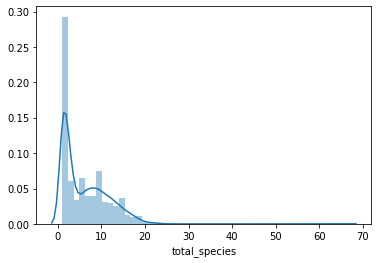

In [71]:
sns.distplot(presence_rsi['total_species'])

In [78]:
print(len(species_name_df['English_name'].unique()))
print(species_name_df['English_name'].unique())

40
['largemouth_bass' 'american_eel' 'brown_bullhead' 'channel_catfish'
 'white_perch' 'chain_pickerel' 'common_carp' 'silver_redhorse'
 'shorthead_redhorse' 'cisco' 'rock_bass' 'walleye' 'sauger'
 'lake_sturgeon' 'gulf_sturgeon' 'greenland_halibut' 'northern_pike'
 'lake_whitefish' 'goldeneye' 'burbot' 'freshwater_drum' 'black_crappie'
 'muskellunge' 'white_sucker' 'longnose_sucker' 'rock_cod' 'redhorse'
 'round_whitefish' 'arctic_chair' 'brook_trout' 'atlantic_salmon'
 'fallfish' 'yellow_perch' 'winter_cod' 'rose_fish' 'lake_trout'
 'rainbow_trout' 'brown_trout' 'splake' 'rainbow_smelt']


In [80]:
print(len(rsi_pres['Taxon'].unique()))
print(rsi_pres['Taxon'].unique())

223
['striped_bass' 'american_shad' 'white_sucker' 'channel_catfish' 'mooneye'
 'walleye' 'lake_sturgeon' 'rainbow_smelt' 'longnose_sucker' 'alewife'
 'american_eel' 'white_perch' 'quillback' 'smallmouth_bass'
 'silver_redhorse' 'logperch' 'tessellated_darter' 'brown_bullhead'
 'longnose_gar' 'freshwater_drum' 'fallfish' 'channel_darter'
 'emerald_shiner' 'johnny_darter' 'tadpole_madtom' 'trout-perch'
 'chestnut_lamprey' 'largemouth_bass' 'black_crappie' 'winter_flounder'
 'three-spined_stickleback' 'sand_shiner' 'common_carp' 'bowfin'
 'greater_redhorse' 'atlantic_mackerel' 'brook_trout' 'atlantic_snailfish'
 'greenland_cod' 'muskellunge' 'northern_pike' 'cisco' 'banded_killifish'
 'ocean_pout' 'ninespine_stickleback' 'polar_cod' 'tench'
 'atlantic_sturgeon' 'atlantic_herring' 'burbot' 'shorthead_redhorse'
 'mottled_sculpin' 'yellow_bullhead' 'american_gizzard_shad'
 'american_sand_lance' 'mimic_shiner' 'rock_bass' 'silver_lamprey'
 'golden_shiner' 'round_goby' 'atlantic_tomcod' 'lake

In [101]:
common_species = list(set(rsi_pres['Taxon'].unique()) & set(species_name_df['English_name'].unique()))
print(len(common_names), common_names)

31 ['walleye', 'brown_trout', 'fallfish', 'white_perch', 'rainbow_smelt', 'chain_pickerel', 'black_crappie', 'cisco', 'brown_bullhead', 'lake_trout', 'brook_trout', 'american_eel', 'silver_redhorse', 'rainbow_trout', 'muskellunge', 'northern_pike', 'lake_whitefish', 'channel_catfish', 'greenland_halibut', 'burbot', 'longnose_sucker', 'sauger', 'common_carp', 'rock_bass', 'lake_sturgeon', 'atlantic_salmon', 'shorthead_redhorse', 'yellow_perch', 'largemouth_bass', 'white_sucker', 'freshwater_drum']


In [102]:
[item for item in species_name_df['English_name'].unique() if item not in common_species]

['gulf_sturgeon',
 'goldeneye',
 'rock_cod',
 'redhorse',
 'round_whitefish',
 'arctic_char',
 'winter_cod',
 'rose_fish',
 'splake']

In [104]:
rsi_pres['Taxon'].unique()

array(['striped_bass', 'american_shad', 'white_sucker', 'channel_catfish',
       'mooneye', 'walleye', 'lake_sturgeon', 'rainbow_smelt',
       'longnose_sucker', 'alewife', 'american_eel', 'white_perch',
       'quillback', 'smallmouth_bass', 'silver_redhorse', 'logperch',
       'tessellated_darter', 'brown_bullhead', 'longnose_gar',
       'freshwater_drum', 'fallfish', 'channel_darter', 'emerald_shiner',
       'johnny_darter', 'tadpole_madtom', 'trout-perch',
       'chestnut_lamprey', 'largemouth_bass', 'black_crappie',
       'winter_flounder', 'three-spined_stickleback', 'sand_shiner',
       'common_carp', 'bowfin', 'greater_redhorse', 'atlantic_mackerel',
       'brook_trout', 'atlantic_snailfish', 'greenland_cod',
       'muskellunge', 'northern_pike', 'cisco', 'banded_killifish',
       'ocean_pout', 'ninespine_stickleback', 'polar_cod', 'tench',
       'atlantic_sturgeon', 'atlantic_herring', 'burbot',
       'shorthead_redhorse', 'mottled_sculpin', 'yellow_bullhead',
   

### That's it folks!